# **Load in some Libraries**

In [1]:
from keras.utils import to_categorical
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import time
import copy
from torch.utils.data import Dataset
from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import transforms
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix
import torchvision.transforms as transforms
import torchvision.models as models
import plotly.express as px
from matplotlib.backends.backend_pdf import PdfPages
import warnings
from matplotlib.colors import LinearSegmentedColormap
import cv2
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


# **Load in CSV of watermark data** 

In [ ]:
df = pd.read_csv('/gdrive/My Drive/Image specification for AI training - Sheet1 (3).csv')

#list of images
image_paths = df['Path'].tolist()
del image_paths[2500:]
print(len(image_paths))

for image in range(len(image_paths)):
  image_paths[image] = image_paths[image].replace('C:\\Users\\leeeg\\Downloads\\student_data\\student_data', '/gdrive/My Drive/student_data/')
  image_paths[image] = image_paths[image].replace('//',"/")
  image_paths[image] = image_paths[image].replace('\\',"/")
len(image_paths)

#list of labels
labels = []
for i in range(2500):
  row = df.iloc[i]

# Search for the letter 'x' in the row for the csv

  for i, element in enumerate(row):
      if 'x' in str(element) and i != 0:
          labels.append(i)
          break
len(labels)

everything_dictionary = {}
for name in image_paths:
    everything_dictionary[name] = labels[image_paths.index(name)]

len(everything_dictionary)

label_counts = {}
train = {}
val = {}
for image, label in everything_dictionary.items():
    if label not in label_counts:
        label_counts[label] = 0
    label_counts[label] += 1

for image, label in everything_dictionary.items():
    if label_counts[label] % 5 == 0: #because 20% of the time the remainder is 5
        val[image] = label
    else:
        train[image] = label
    label_counts[label] -= 1
train = {k: v for k, v in sorted(train.items(), key=lambda item: item[1])}
val = {k: v for k, v in sorted(val.items(), key=lambda item: item[1])}

d = val
new_d = {}
for key in d:
    new_key = key.replace("//", "/")
    new_d[new_key] = d[key]
val = new_d

2500


In [ ]:
#list of images
image_paths = df['Path'].tolist()
del image_paths[2500:]
print(len(image_paths))

2500


In [ ]:
#Replace the path names so that it's in the format that takes the images from google drive
for image in range(len(image_paths)):
  image_paths[image] = image_paths[image].replace('C:\\Users\\leeeg\\Downloads\\student_data\\student_data', '/gdrive/My Drive/student_data/')
  image_paths[image] = image_paths[image].replace('//',"/")
  image_paths[image] = image_paths[image].replace('\\',"/")
len(image_paths)

2500

In [ ]:
#list of labels
labels = []
for i in range(2500):
  row = df.iloc[i]

# Search for the letter 'x' in the row for the csv

  for i, element in enumerate(row):
      if 'x' in str(element) and i != 0:
          labels.append(i)
          break
len(labels)

2500

In [ ]:
everything_dictionary = {}
for name in image_paths:
    everything_dictionary[name] = labels[image_paths.index(name)]

len(everything_dictionary)

2500

# **Visualize the different Classes**

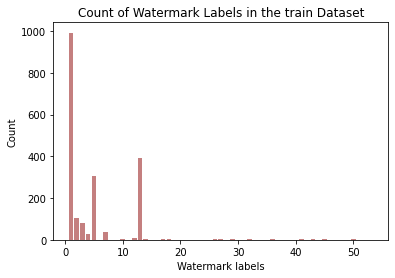

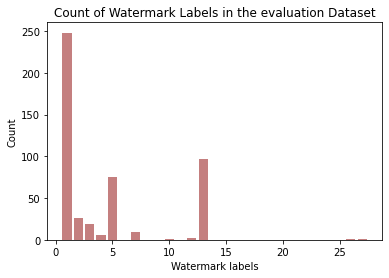

In [ ]:
def bargraph(dictionary, datasetname): 

  keys = list(dictionary.keys())
  values = list(dictionary.values())


  # Create frequency dictionary
  frequency = {}
  for value in values:
      if value in frequency:
          frequency[value] += 1
      else:
          frequency[value] = 1

  # Get frequency keys and values
  f_keys = list(frequency.keys())
  f_values = list(frequency.values())

  # Create bar graph
  fig, ax = plt.subplots()
  ax.bar(f_keys, f_values, color = '#8B0000', alpha = 0.5)

  # Add title and labels
  plt.title(('Count of Watermark Labels in the ') + datasetname + (' Dataset'))
  plt.xlabel('Watermark labels')
  plt.ylabel('Count')
  
  # Show graph
  plt.show()
  
bargraph(train, 'train')
bargraph(val, 'evaluation')

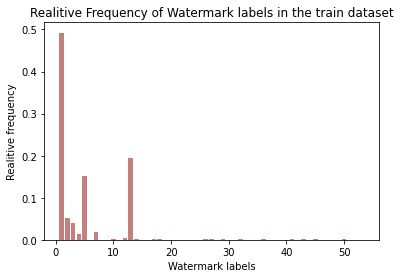

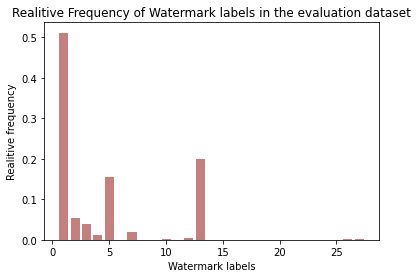

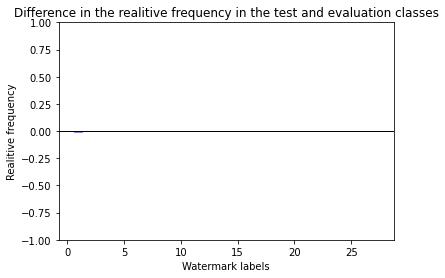

In [ ]:
def normalize_dict_values(dictionary):
    total = sum(dictionary.values())
    for key in dictionary:
        dictionary[key] /= total
    return dictionary

#transform train to frequency of values
keys = list(train.keys())
values = list(train.values())
frequency = {}
for value in values:
    if value in frequency:
        frequency[value] += 1
    else:
        frequency[value] = 1

#transform train to frequency of values
keys = list(val.keys())
values = list(val.values())
frequency1 = {}
for value in values:
    if value in frequency1:
        frequency1[value] += 1
    else:
        frequency1[value] = 1


frequency = normalize_dict_values(frequency)
frequency1 = normalize_dict_values(frequency1)

def bar_graph(dict, ylabel, xlabel, title):
    plt.bar(dict.keys(), dict.values(), color = '#8B0000', alpha = 0.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
bar_graph(frequency, 'Realitive frequency', 'Watermark labels', 'Realitive Frequency of Watermark labels in the train dataset')
bar_graph(frequency1, 'Realitive frequency', 'Watermark labels', 'Realitive Frequency of Watermark labels in the evaluation dataset')

def subtract_dicts(train, val):
    result = {}
    for key in train:
        if key in val:
            result[key] = train[key] - val[key]
    return result

def special_bar_graph(dict, ylabel, xlabel, title, ymin=None, ymax=None):
    values = np.array(list(dict.values()))
    above_0 = np.where(values >= 0, values, 0)
    below_0 = np.where(values < 0, values, 0)

    plt.bar(dict.keys(), above_0, color='red', alpha=0.5)
    plt.bar(dict.keys(), below_0, color='blue', alpha=0.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axhline(y=0, color='black', linewidth=1)
    plt.title(title)
    if ymin is not None:
      plt.ylim(bottom=ymin)
    if ymax is not None:
      plt.ylim(top=ymax)
    plt.show()

special_bar_graph(subtract_dicts(frequency, frequency1), 'Realitive frequency', 'Watermark labels', 'Difference in the realitive frequency in the test and evaluation classes', -1, 1)

# **Preprocess data** 

In [ ]:
cudnn.benchmark = True
plt.ion()   # interactive mode
class CustomImageDataset(Dataset):
    def __init__(self, image_paths_dict, transforms=None):
        super().__init__()
        self.image_paths_dict = image_paths_dict
        self.transforms = transforms

    def __len__(self):
        return len(self.image_paths_dict)

    def __getitem__(self, index):
        image_paths = list(self.image_paths_dict.keys())[index]
        label = list(self.image_paths_dict.values())[index]

        try:
            image = Image.open(image_paths).convert('RGB')

        except:
            # save to file
            random_idx = np.random.choice(len(image_paths))
            with open('none_importable_images.txt','a+') as fh:
                fh.write(image_paths +',' + image_paths[random_idx] + '\n')
            return self.__getitem__(random_idx)

        if self.transforms is not None:
            image = self.transforms(image)

        return image, label

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
train_dataset = CustomImageDataset(image_paths_dict = train, transforms=data_transforms['train'])
val_dataset = CustomImageDataset(image_paths_dict = val, transforms=data_transforms['val'])

# Create a dictionary of dataloaders
dataloaders = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
}

# Get the size of the datasets
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

# Get the class names
class_names = train_dataset.image_paths_dict.values()

# Get the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



# **Define the Function to Train the model**

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10) 

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {list(class_names)[preds[j]]}') #transfer to cpu
                #imshow(inputs.cpu().data[j])
                imshow(transforms.ToPILImage()(inputs.cpu().data[j]))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 54)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

# **Run the model (takes a couple hours)**

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

In [ ]:
torch.save(model_ft.state_dict(), "/gdrive/My Drive/watermark_model.pt")

# **Use the model to make predictions** 

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.



tensor([1])
/gdrive/My Drive/student_data/cs_scrapped/genodermatoses-and-supernumerary-growths_ichthyosis_x-linked-ichthyosis/48800.png


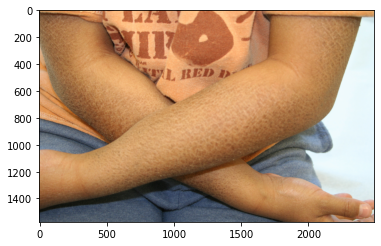

Normal
The right answer is Normal


In [ ]:
model = torch.load('/gdrive/My Drive/watermark_model.pt')
model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 54)
model_ft.load_state_dict(torch.load("/gdrive/My Drive/watermark_model.pt"))
model_ft = model_ft.to(device)
model_ft.eval()


#random_image = R'C:\Users\leeeg\Downloads\student_data\student_data\cs_scrapped\inflammatory_diseases-of-bone\69175.png' 
random_image = random.choice(list(val.keys()))
#make  formating changes if you wanna do your own image
random_image = random_image.replace('C:\\Users\\leeeg\\Downloads\\student_data\\student_data', '/gdrive/My Drive/student_data/')
random_image = random_image.replace('//',"/")
random_image = random_image.replace('\\',"/")
#transform to a tensor
transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
#converts to rgb and transforms
image = Image.open(random_image).convert('RGB')
inputs = transform(image)
with torch.no_grad():
    inputs = inputs.unsqueeze(0).to(device)
    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)
    print(preds)
    print(random_image)
    img = mpimg.imread(random_image)
    plt.imshow(img)
    plt.show()
    preds = str(preds)
    preds = preds.replace('tensor([', '')
    preds = preds.replace('])', '')
    preds = int(preds)
    diagnosis = column_title = df.columns[preds]
    print(diagnosis)

    if random_image in val:
        key = val[random_image]
        correct = column_title = df.columns[key]
        print('The right answer is ' + correct)
    else:
        print('idk the right answer')


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-54-91149b16696d>", line 63, in <module>
    plot_images(images, pdf_file) #plot said images onto pdf
  File "<ipython-input-54-91149b16696d>", line 57, in plot_images
    plt.title('Predicted: ' + get_prediction(image_paths[get_index(image_path, image_paths)]))
  File "<ipython-input-54-91149b16696d>", line 39, in get_prediction
    img = mpimg.imread(random_image)
  File "/usr/local/lib/python3.8/dist-packages/matplotlib/image.py", line 1475, in imread
    return _png.read_png(file)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'Keyboar

KeyboardInterrupt: ignored

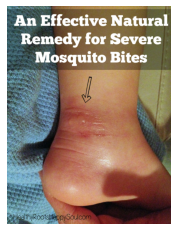

In [ ]:
#@title Make a PDF of predictions
#New Dataframe of just images the model hasn't been trained on
df1 =  pd.read_csv('/gdrive/My Drive/Testing AI Data - Sheet1.csv')
image_paths = df1['Path'].tolist()
len(image_paths)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for i in range(len(image_paths)):
  image_paths[i] = image_paths[i].replace('C:\\Users\\leeeg\\Downloads\\student_data\\student_data', '/gdrive/My Drive/student_data/')
  image_paths[i] = image_paths[i].replace('//',"/")
  image_paths[i] = image_paths[i].replace('\\',"/")
  image_paths[i] = image_paths[i].replace('//',"/")


def random_sample(large_list, sample_size):
    return random.sample(large_list, sample_size)

def get_prediction(random_image):
  model = torch.load('/gdrive/My Drive/watermark_model.pt')
  model_ft = models.resnet18(pretrained=False)
  num_ftrs = model_ft.fc.in_features
  model_ft.fc = nn.Linear(num_ftrs, 54)
  model_ft.load_state_dict(torch.load("/gdrive/My Drive/watermark_model.pt"))
  model_ft = model_ft.to(device)
  model_ft.eval()

  #transform to a tensor
  transform = transforms.Compose([
          transforms.Resize((256, 256)),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ])
  #converts to rgb and transforms
  image = Image.open(random_image).convert('RGB')
  inputs = transform(image)
  with torch.no_grad():
      inputs = inputs.unsqueeze(0).to(device)
      outputs = model_ft(inputs)
      _, preds = torch.max(outputs, 1)
      img = mpimg.imread(random_image)
      plt.imshow(img)
      preds = str(preds)
      preds = preds.replace('tensor([', '')
      preds = preds.replace('])', '')
      preds = int(preds)
      diagnosis = column_title = df.columns[preds]
      return diagnosis

def get_index(element, my_list):
    return my_list.index(element)

def plot_images(image_paths, pdf_file):
    with PdfPages(pdf_file) as pdf:
        for image_path in image_paths:
            image = mpimg.imread(image_path)
            plt.imshow(image)
            plt.axis('off')
            plt.title('Predicted: ' + get_prediction(image_paths[get_index(image_path, image_paths)]))
            pdf.savefig()
            plt.close()

images = random_sample(image_paths, 50)
pdf_file = '/gdrive/My Drive/AIPredictions.pdf'
plot_images(images, pdf_file) #plot said images onto pdf

# **Collect Data for a confusion matrix (takes 10ish mins)**

In [ ]:
true_labels = []
predicted_labels = []
for i in range(485):
  correct = ''
  
  model = torch.load('/gdrive/My Drive/watermark_model.pt')
  model_ft = models.resnet18(pretrained=False)
  num_ftrs = model_ft.fc.in_features
  model_ft.fc = nn.Linear(num_ftrs, 54)
  model_ft.load_state_dict(torch.load("/gdrive/My Drive/watermark_model.pt"))
  model_ft = model_ft.to(device)
  model_ft.eval()


  #random_image = R'C:\Users\leeeg\Downloads\student_data\student_data\cs_scrapped\inflammatory_urticaria-and-angioedema_urticaria\86706.png' 
  random_image = list(val.keys())[i]
  print(random_image)
  #make  formating changes if you wanna do your own image
  random_image = random_image.replace('C:\\Users\\leeeg\\Downloads\\student_data\\student_data', '/gdrive/My Drive/student_data/')
  random_image = random_image.replace('//',"/")
  random_image = random_image.replace('\\',"/")
  #transform to a tensor
  transform = transforms.Compose([
          transforms.Resize((256, 256)),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ])
  #converts to rgb and transforms
  image = Image.open(random_image).convert('RGB')
  inputs = transform(image)
  with torch.no_grad():
      inputs = inputs.unsqueeze(0).to(device)
      outputs = model_ft(inputs)
      _, preds = torch.max(outputs, 1)
      img = mpimg.imread(random_image)
      preds = str(preds)
      preds = preds.replace('tensor([', '')
      preds = preds.replace('])', '')
      preds = int(preds)
      diagnosis = column_title = df.columns[preds]
      print(diagnosis)

      if random_image in val:
          key = val[random_image]
          correct = column_title = df.columns[key]
          print('The right answer is ' + correct)
      else:
          print('idk the right answer')
      true_labels.append(correct)
      predicted_labels.append(diagnosis)



/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


/gdrive/My Drive/student_data/cs_scrapped/pigmented-lesions-benign_naevus-achromic/106321.png
Normal
The right answer is Normal
/gdrive/My Drive/student_data/cs_scrapped/inflammatory_infections_viral-diseaseshpv-herpes-molluscum-exanthems-and-others_herpes-simplex_eczema-herpeticum/103019.png
Normal
The right answer is Normal
/gdrive/My Drive/student_data/cs_scrapped/inflammatory_eczema-spongiotic-dermatitis_eczema-hand/53532.png
Normal
The right answer is Normal
/gdrive/My Drive/student_data/cs_scrapped/inflammatory_gyrate-erythemas/72456.png
Normal
The right answer is Normal
/gdrive/My Drive/student_data/cs_scrapped/inflammatory_gyrate-erythemas/35349.png
Normal
The right answer is Normal
/gdrive/My Drive/student_data/cs_scrapped/inflammatory_gyrate-erythemas/100507.png
Normal
The right answer is Normal
/gdrive/My Drive/student_data/cs_scrapped/inflammatory_gyrate-erythemas/95413.png
Normal
The right answer is Normal
/gdrive/My Drive/student_data/cs_scrapped/inflammatory_gyrate-eryth

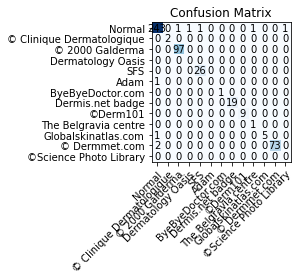

In [ ]:
#numpy.argsort

actual = true_labels
predicted = predicted_labels

classes = list(set(actual + predicted))
n_classes = len(classes)

confusion_matrix = np.zeros((n_classes, n_classes), dtype=int)

for i in range(len(actual)):
    true_class_index = classes.index(actual[i])
    predicted_class_index = classes.index(predicted[i])
    confusion_matrix[true_class_index][predicted_class_index] += 1

fig, ax = plt.subplots()
im = ax.imshow(confusion_matrix, cmap='Blues')

ax.set_xticks(np.arange(n_classes))
ax.set_yticks(np.arange(n_classes))

ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for i in range(n_classes):
    for j in range(n_classes):
        text = ax.text(j, i, confusion_matrix[i, j], ha="center", va="center", color="black")

ax.set_title("Confusion Matrix")
fig.tight_layout()
plt.show()


# **Umap**

In [ ]:
pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import umap

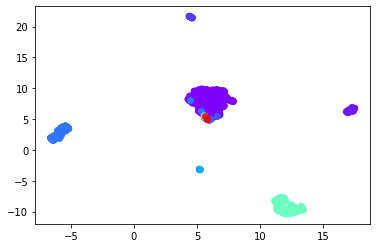

In [ ]:
#@title 2D Umap
model = torch.load('/gdrive/My Drive/watermark_model.pt')
model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 54)
model_ft.load_state_dict(torch.load("/gdrive/My Drive/watermark_model.pt"))
model_ft = model_ft.to(device)
model_ft.eval()


transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data = []
for image_path in val.keys():
    image = Image.open(image_path).convert('RGB')
    inputs = transform(image)
    with torch.no_grad():
        inputs = inputs.unsqueeze(0).to(device)
        outputs = model_ft(inputs)
        data.append(outputs.flatten().numpy())

data = np.array(data)

reducer = umap.UMAP(n_components=2)
umap_features = reducer.fit_transform(data)

plt.scatter(umap_features[:, 0], umap_features[:, 1], c=list(val.values()), cmap='rainbow')

plt.show()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.



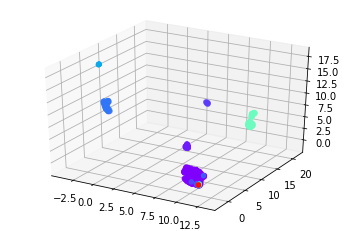

In [ ]:
#@title 3D Umap
model = torch.load('/gdrive/My Drive/watermark_model.pt')
model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 54)
model_ft.load_state_dict(torch.load("/gdrive/My Drive/watermark_model.pt"))
model_ft = model_ft.to(device)
model_ft.eval()





transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data = []
for image_path in val.keys():
    
    image = Image.open(image_path).convert('RGB')
    inputs = transform(image)
    with torch.no_grad():
        inputs = inputs.unsqueeze(0).to(device)
        outputs = model_ft(inputs)
        data.append(outputs.flatten().numpy())

data = np.array(data)


reducer = umap.UMAP(n_components=3)
embedding = reducer.fit_transform(data)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=list(val.values()), cmap='rainbow')
plt.show()

In [ ]:
reducer = umap.UMAP(n_components=3)
embedding = reducer.fit_transform(data)

In [ ]:
#@title 3D (Interactive)
actual = true_labels
predicted = predicted_labels
labels = [f'Predicted: {p}<br>Actual: {a}' for p, a in zip(predicted, actual)]
data = pd.DataFrame({'x': embedding[:, 0], 'y': embedding[:, 1], 'z': embedding[:, 2], 'color': list(val.values()), 'text': labels})
fig = px.scatter_3d(data, x='x', y='y', z='z', color='color', color_continuous_scale='rainbow', labels='text', hover_data=["text"])
print("Number of points on the scatter plot:", len(embedding))
fig.show()


Number of points on the scatter plot: 485


# **Saliency Maps**

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.



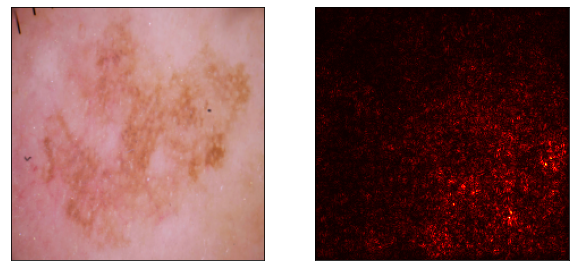

Prediction: Normal


In [ ]:
#@title Plot a random image to a saliency map with prediction
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.load('/gdrive/My Drive/watermark_model.pt')
model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 54)
model_ft.load_state_dict(torch.load("/gdrive/My Drive/watermark_model.pt"))
model_ft = model_ft.to(device)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,          
])

def saliency(img, model):
  
    for param in model.parameters():
        param.requires_grad = False
    
    model.eval()
    #transoform input PIL image to torch.Tensor and normalize
    input = transform(img)
    input.unsqueeze_(0)

    #we want to calculate gradient of higest score w.r.t. input
    #so set requires_grad to True for input 
    input.requires_grad = True

    preds = model(input)
    score, indices = torch.max(preds, 1)
    score.backward()
  
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
 
    slc = (slc - slc.min())/(slc.max()-slc.min())

   
    with torch.no_grad():
        input_img = inv_normalize(input[0])
 
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(input_img.detach().numpy(), (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(slc.numpy(), cmap=plt.cm.hot)
    plt.xticks([])
    plt.yticks([])
    plt.show()
def get_prediction_label(random_image):
  model = torch.load('/gdrive/My Drive/watermark_model.pt')
  model_ft = models.resnet18(pretrained=False)
  num_ftrs = model_ft.fc.in_features
  model_ft.fc = nn.Linear(num_ftrs, 54)
  model_ft.load_state_dict(torch.load("/gdrive/My Drive/watermark_model.pt"))
  model_ft = model_ft.to(device)
  model_ft.eval()


  transform = transforms.Compose([
          transforms.Resize((256, 256)),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ])

  image = Image.open(random_image).convert('RGB')
  inputs = transform(image)
  with torch.no_grad():
      inputs = inputs.unsqueeze(0).to(device)
      outputs = model_ft(inputs)
      _, preds = torch.max(outputs, 1)
      img = mpimg.imread(random_image)
      preds = str(preds)
      preds = preds.replace('tensor([', '')
      preds = preds.replace('])', '')
      preds = int(preds)
      diagnosis = column_title = df.columns[preds]
      return diagnosis

img1 = random.choice(image_paths)
img = Image.open(img1).convert('RGB')
saliency(img, model_ft)
print('Prediction: ' + get_prediction_label(img1))

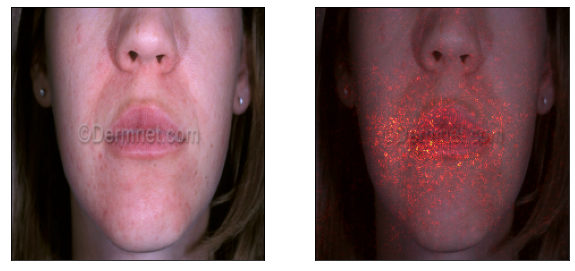

Prediction: © Dermmet.com


In [ ]:
def saliency(img, model):

    for param in model.parameters():
        param.requires_grad = False
    
  
    model.eval()
  
    input = transform(img)
    input.unsqueeze_(0)

  
    input.requires_grad = True

    preds = model(input)
    score, indices = torch.max(preds, 1)
 
    score.backward()

    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)

    slc = (slc - slc.min())/(slc.max()-slc.min())

    with torch.no_grad():
        input_img = inv_normalize(input[0])
    
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(1, 2, 1)
    ax.imshow(np.transpose(input_img.detach().numpy(), (1, 2, 0)))
    ax.set_xticks([])
    ax.set_yticks([])
    ax = plt.subplot(1, 2, 2)
    ax.imshow(np.transpose(input_img.detach().numpy(), (1, 2, 0)))
    ax.imshow(slc.numpy(), alpha=0.5, cmap=plt.cm.hot)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
img1 = random.choice(image_paths)
img = Image.open(img1).convert('RGB')
saliency(img, model_ft)
print('Prediction: ' + get_prediction_label(img1))

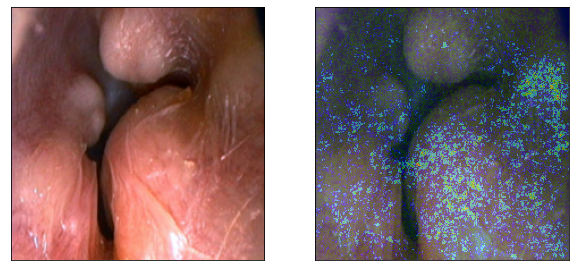

Prediction: Normal


In [ ]:
def saliency(img, model):
    for param in model.parameters():
        param.requires_grad = False
    

    model.eval()
  
    input = transform(img)
    input.unsqueeze_(0)


    input.requires_grad = True

    preds = model(input)
    score, indices = torch.max(preds, 1)

    score.backward()
   
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)

    slc = (slc - slc.min())/(slc.max()-slc.min())


    with torch.no_grad():
        input_img = inv_normalize(input[0])
    
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(1, 2, 1)
    ax.imshow(np.transpose(input_img.detach().numpy(), (1, 2, 0)))
    ax.set_xticks([])
    ax.set_yticks([])
    ax = plt.subplot(1, 2, 2)
    ax.imshow(np.transpose(input_img.detach().numpy(), (1, 2, 0)))
    ax.imshow(slc.numpy(), alpha=0.5, cmap=plt.cm.gist_ncar)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
img1 = random.choice(image_paths)
img = Image.open(img1).convert('RGB')
saliency(img, model_ft)
print('Prediction: ' + get_prediction_label(img1))

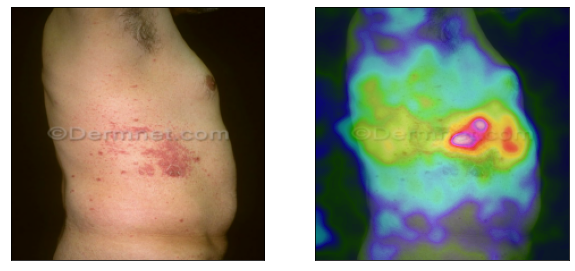

Prediction: © Dermmet.com


In [ ]:
def saliency(img, model):

    for param in model.parameters():
        param.requires_grad = False

    model.eval()

    input = transform(img)
    input.unsqueeze_(0)
    input.requires_grad = True

    preds = model(input)
    score, indices = torch.max(preds, 1)
   
    score.backward()

    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)

    slc = (slc - slc.min())/(slc.max()-slc.min())

    #Gaussian blur to the saliency map
    slc = slc.numpy()
    slc = cv2.GaussianBlur(slc, (25, 25), 0)
    slc = torch.from_numpy(slc)

   
    with torch.no_grad():
        input_img = inv_normalize(input[0])
    
    #plot image and its saliency map overlaid
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(1, 2, 1)
    ax.imshow(np.transpose(input_img.detach().numpy(), (1, 2, 0)))
    ax.set_xticks([])
    ax.set_yticks([])
    ax = plt.subplot(1, 2, 2)
    ax.imshow(np.transpose(input_img.detach().numpy(), (1, 2, 0)))
    ax.imshow(slc.numpy(), alpha=0.5, cmap=plt.cm.gist_ncar)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()


img1 = random.choice(image_paths)
img = Image.open(img1).convert('RGB')
saliency(img, model_ft)
print('Prediction: ' + get_prediction_label(img1))